<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_15_resampling_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Description

We are continuing our efforts to predict loan defaults using the "Default of Credit Card Clients" dataset. The target variable remains highly imbalanced, with significantly more instances of non-defaults compared to defaults. Our objective is to improve the recall for the minority class (defaults) while maintaining balanced F1 and macro F1 scores. Following our experimentation with the Random Forest and SVM models, we now turn our focus to using SMOTE (Synthetic Minority Over-sampling Technique) with a Logistic Regression model.

### Previous Observations with Random Forest and SVM

We observed that applying random oversampling improved the recall for the minority class, but with a trade-off in balanced and macro F1 scores. This suggests that resampling helps the models better identify loan defaults, though it may also increase misclassifications of non-defaults.

### Experimental Approach with Logistic Regression and SMOTE

To further investigate the impact of resampling, we will experiment with Logistic Regression using SMOTE. SMOTE generates synthetic samples for the minority class to balance the dataset, which can often lead to better model performance on imbalanced datasets.

Our experimental approach involves three main steps:

1. **Baseline Model**: Train and evaluate a Logistic Regression model without any resampling.
2. **Resampling Inside the Pipeline**: Integrate SMOTE within the pipeline and evaluate the performance.
3. **Resampling Outside the Pipeline**: Apply SMOTE before fitting the pipeline and evaluate the performance.

### Summary

1. **Define Baseline Logistic Regression Model**: Set up and evaluate the baseline Logistic Regression model without resampling.
2. **Resampling Inside Pipeline**: Integrate the SMOTE step within the pipeline and evaluate.
3. **Resampling Outside Pipeline**: Apply SMOTE before fitting the pipeline and evaluate.
4. **Combine and Compare Results**: Combine and visualize the results for comparison.

This setup will help determine if the Logistic Regression model performs better with SMOTE resampling and how it compares to the baseline model.

### No Resampling Baseline Model

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score
from loan_data_utils import load_and_preprocess_data
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the logistic regression model with class weights
logreg_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Create the baseline pipeline
baseline_pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg_model)
])

# Fit the baseline pipeline to the training data
baseline_pipeline_logreg.fit(X_train, y_train)

# Predict probabilities for the test data
optimal_threshold = 0.25
baseline_y_proba_logreg = baseline_pipeline_logreg.predict_proba(X_test)[:, 1]
baseline_y_pred_logreg = (baseline_y_proba_logreg >= optimal_threshold).astype(int)

# Evaluate the baseline model
baseline_recall_class1_logreg = recall_score(y_test, baseline_y_pred_logreg, pos_label=1)
baseline_f1_balanced_logreg = f1_score(y_test, baseline_y_pred_logreg, average='binary', pos_label=1)
baseline_f1_macro_logreg = f1_score(y_test, baseline_y_pred_logreg, average='macro')

print("Baseline Logistic Regression Model Performance with Optimal Threshold:")
print(f"Recall Class 1: {baseline_recall_class1_logreg:.4f}")
print(f"F1 Score (balanced): {baseline_f1_balanced_logreg:.4f}")
print(f"F1 Score (macro): {baseline_f1_macro_logreg:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, baseline_y_pred_logreg))

# Save the baseline results
baseline_results_logreg = {
    'Method': 'Baseline Logistic Regression',
    'Recall Class 1': baseline_recall_class1_logreg,
    'F1 Score (balanced)': baseline_f1_balanced_logreg,
    'F1 Score (macro)': baseline_f1_macro_logreg,
    'Threshold': 'Optimal (0.25)'
}


Baseline Logistic Regression Model Performance with Optimal Threshold:
Recall Class 1: 0.9254
F1 Score (balanced): 0.3795
F1 Score (macro): 0.3265

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.93      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000



### Resampling inside Pipeline



In [4]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define the resampling method
resampler_inside_logreg = SMOTE(random_state=42)

# Create the resampled pipeline
resampled_pipeline_inside_logreg = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler_inside_logreg),
    ('classifier', logreg_model)
])

# Fit the resampled pipeline to the training data
resampled_pipeline_inside_logreg.fit(X_train, y_train)

# Predict probabilities for the test data
resampled_y_proba_inside_logreg = resampled_pipeline_inside_logreg.predict_proba(X_test)[:, 1]
resampled_y_pred_inside_logreg = (resampled_y_proba_inside_logreg >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_inside_logreg = recall_score(y_test, resampled_y_pred_inside_logreg, pos_label=1)
resampled_f1_balanced_inside_logreg = f1_score(y_test, resampled_y_pred_inside_logreg, average='binary', pos_label=1)
resampled_f1_macro_inside_logreg = f1_score(y_test, resampled_y_pred_inside_logreg, average='macro')

print("Resampled Logistic Regression Model Performance with Optimal Threshold (Inside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_inside_logreg:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_inside_logreg:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_inside_logreg:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_inside_logreg))

# Save the resampled results
resampled_results_inside_logreg = {
    'Method': 'SMOTE Logistic Regression (Inside Pipeline)',
    'Recall Class 1': resampled_recall_class1_inside_logreg,
    'F1 Score (balanced)': resampled_f1_balanced_inside_logreg,
    'F1 Score (macro)': resampled_f1_macro_inside_logreg,
    'Threshold': 'Optimal (0.25)'
}


Resampled Logistic Regression Model Performance with Optimal Threshold (Inside Pipeline):
Recall Class 1: 0.9209
F1 Score (balanced): 0.3835
F1 Score (macro): 0.3426

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.18      0.30      4673
           1       0.24      0.92      0.38      1327

    accuracy                           0.35      6000
   macro avg       0.57      0.55      0.34      6000
weighted avg       0.75      0.35      0.32      6000



### Resampling Outside Pipeline

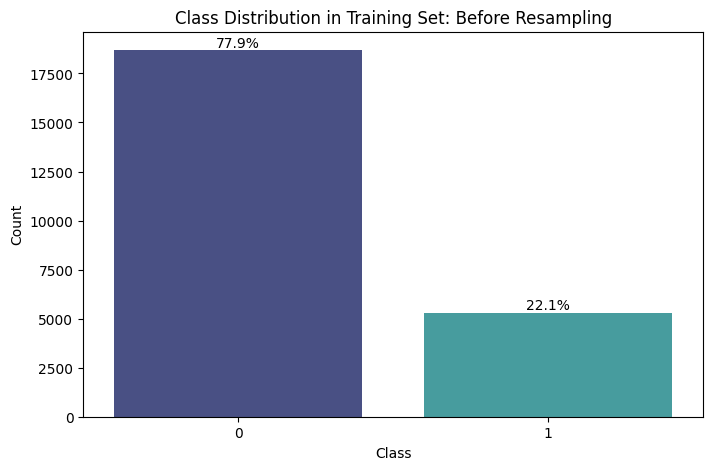

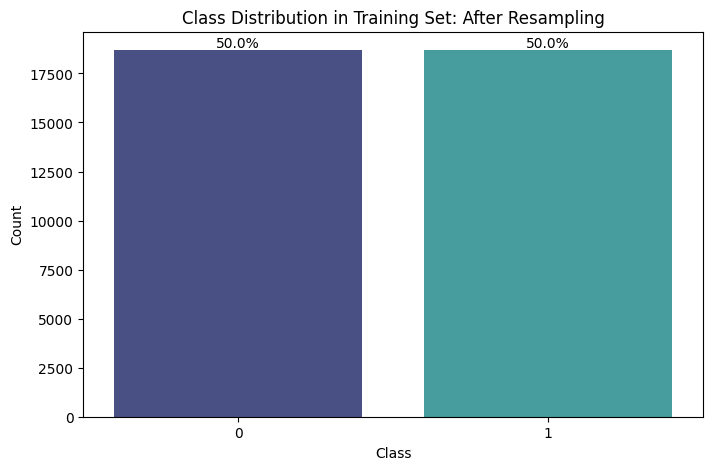

Resampled Logistic Regression Model Performance with Optimal Threshold (Outside Pipeline):
Recall Class 1: 0.8327
F1 Score (balanced): 0.3927
F1 Score (macro): 0.4283

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.32      0.46      4673
           1       0.26      0.83      0.39      1327

    accuracy                           0.43      6000
   macro avg       0.56      0.57      0.43      6000
weighted avg       0.73      0.43      0.45      6000



In [5]:
# Define the resampling method
resampler_outside_logreg = SMOTE(random_state=42)

# Resample the training data
X_resampled_outside_logreg, y_resampled_outside_logreg = resampler_outside_logreg.fit_resample(X_train, y_train)

# Plot class distribution before resampling
plot_class_distribution(y_train, 'Before Resampling')

# Plot class distribution after resampling
plot_class_distribution(y_resampled_outside_logreg, 'After Resampling')

# Create the pipeline
pipeline_outside_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg_model)
])

# Fit the pipeline to the resampled training data
pipeline_outside_logreg.fit(X_resampled_outside_logreg, y_resampled_outside_logreg)

# Predict probabilities for the test data
resampled_y_proba_outside_logreg = pipeline_outside_logreg.predict_proba(X_test)[:, 1]
resampled_y_pred_outside_logreg = (resampled_y_proba_outside_logreg >= optimal_threshold).astype(int)

# Evaluate the model
resampled_recall_class1_outside_logreg = recall_score(y_test, resampled_y_pred_outside_logreg, pos_label=1)
resampled_f1_balanced_outside_logreg = f1_score(y_test, resampled_y_pred_outside_logreg, average='binary', pos_label=1)
resampled_f1_macro_outside_logreg = f1_score(y_test, resampled_y_pred_outside_logreg, average='macro')

print("Resampled Logistic Regression Model Performance with Optimal Threshold (Outside Pipeline):")
print(f"Recall Class 1: {resampled_recall_class1_outside_logreg:.4f}")
print(f"F1 Score (balanced): {resampled_f1_balanced_outside_logreg:.4f}")
print(f"F1 Score (macro): {resampled_f1_macro_outside_logreg:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, resampled_y_pred_outside_logreg))

# Save the resampled results
resampled_results_outside_logreg = {
    'Method': 'SMOTE Logistic Regression (Outside Pipeline)',
    'Recall Class 1': resampled_recall_class1_outside_logreg,
    'F1 Score (balanced)': resampled_f1_balanced_outside_logreg,
    'F1 Score (macro)': resampled_f1_macro_outside_logreg,
    'Threshold': 'Optimal (0.25)'
}


###Compare Results

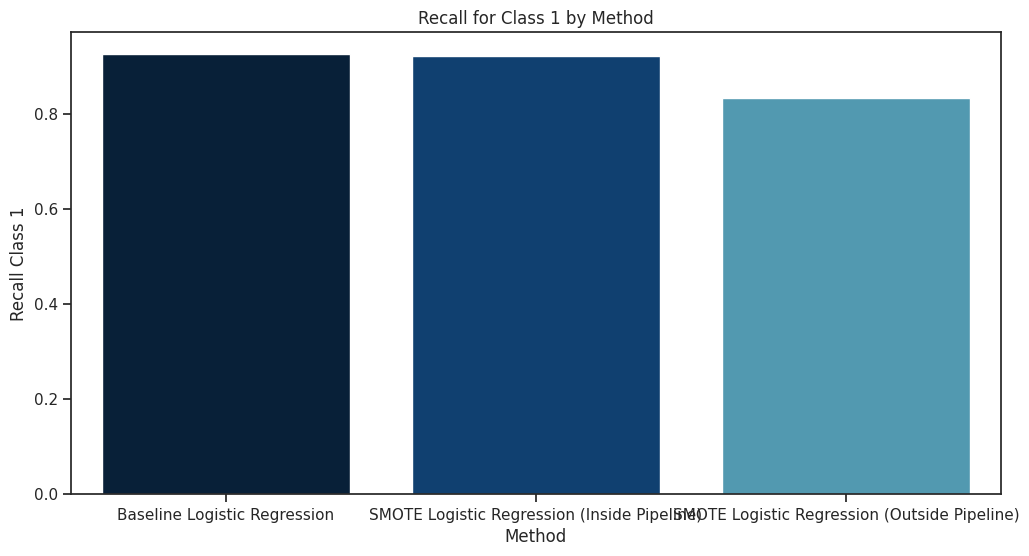

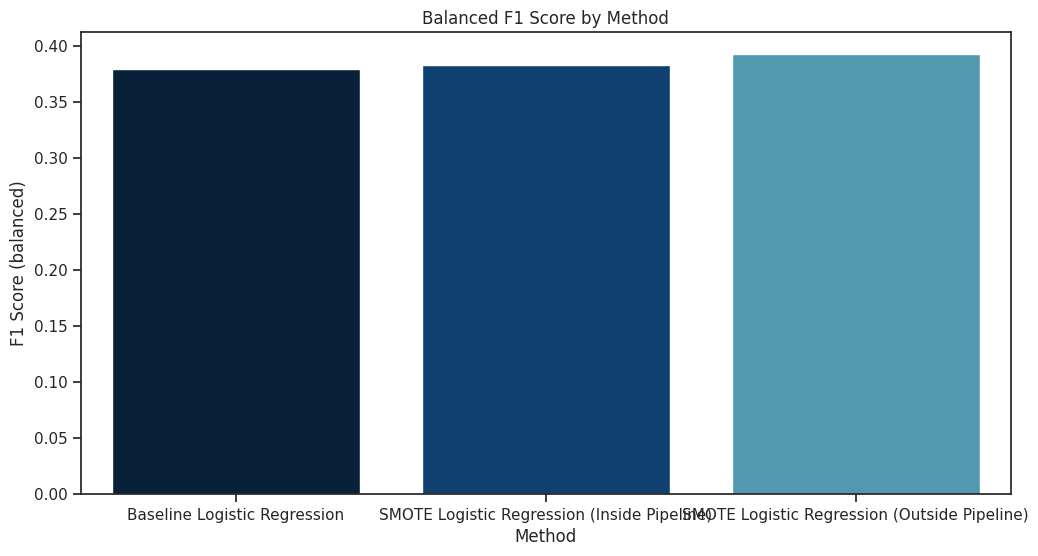

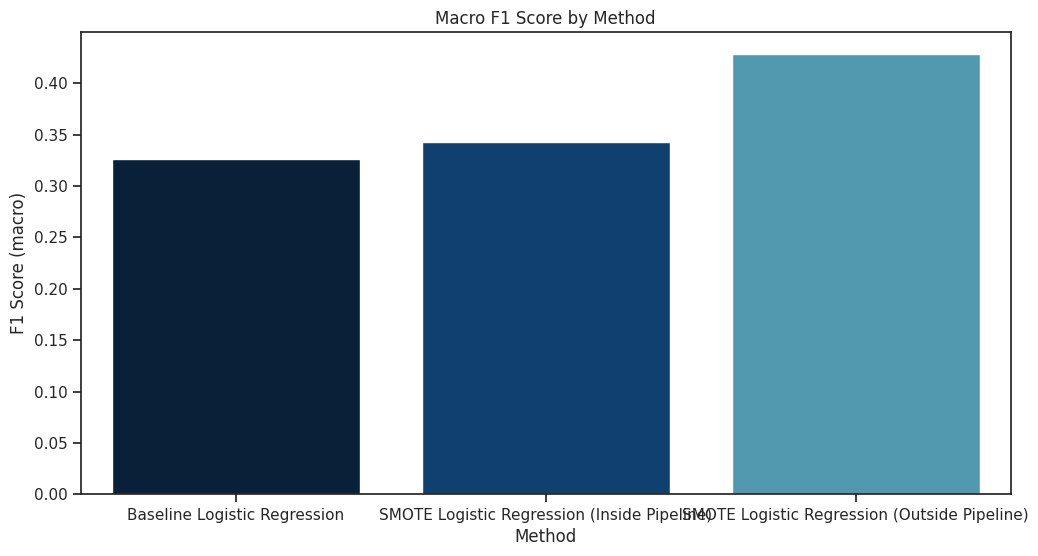

In [9]:
# Combine the results into a single DataFrame
results_df_logreg = pd.DataFrame([baseline_results_logreg, resampled_results_inside_logreg, resampled_results_outside_logreg])

# Function to plot the performance metrics for combined results
def plot_combined_metrics(results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Method', data=results_df, palette='ocean', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    plt.show()

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Method', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Method', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(results_df_logreg, metric, title, ylabel)


In [10]:
# Display the combined results
print("Combined Performance Metrics:")
results_df_logreg

Combined Performance Metrics:


,Method,Recall Class 1,F1 Score (balanced),F1 Score (macro),Threshold
0,Baseline Logistic Regression,0.925396,0.379481,0.326499,Optimal (0.25)
1,SMOTE Logistic Regression (Inside Pipeline),0.920874,0.383493,0.342626,Optimal (0.25)
2,SMOTE Logistic Regression (Outside Pipeline),0.832705,0.392749,0.428291,Optimal (0.25)


### Analysis of SMOTE Results

#### Overview

We experimented with three different setups to improve the recall of the minority class (loan defaults) in our classification task using a Logistic Regression model. The results are summarized as follows:

### Detailed Analysis

1. **Baseline Logistic Regression**:
   - **Recall Class 1**: 0.925396
   - **F1 Score (balanced)**: 0.379481
   - **F1 Score (macro)**: 0.326499
   
   The baseline Logistic Regression model achieves a high recall of approximately 0.93 for the minority class (class 1). This indicates that 93% of actual defaults are correctly identified. However, the balanced F1 score and macro F1 score are relatively low, suggesting poor precision and overall performance across both classes.

2. **SMOTE Logistic Regression (Inside Pipeline)**:
   - **Recall Class 1**: 0.920874
   - **F1 Score (balanced)**: 0.383493
   - **F1 Score (macro)**: 0.342626

   When SMOTE is applied inside the pipeline, the recall for class 1 remains high at approximately 0.92. This is very close to the baseline recall. The balanced F1 score and macro F1 score show slight improvements compared to the baseline, indicating a small improvement in precision and overall performance.

3. **SMOTE Logistic Regression (Outside Pipeline)**:
   - **Recall Class 1**: 0.832705
   - **F1 Score (balanced)**: 0.392749
   - **F1 Score (macro)**: 0.428291

   Applying SMOTE outside the pipeline results in a lower recall for class 1 at approximately 0.83. However, both the balanced F1 score and macro F1 score are significantly higher compared to the baseline and the inside pipeline approach. This suggests better precision and overall performance across both classes.

### Interpretation

- **High Recall in Baseline**: The baseline model already has a very high recall for the minority class, which might be difficult to improve upon.
- **Slight Improvement Inside Pipeline**: Applying SMOTE inside the pipeline results in a minor improvement in F1 scores but maintains high recall. This indicates that SMOTE helps slightly without drastically changing recall.
- **Significant Improvement Outside Pipeline**: SMOTE outside the pipeline shows a more balanced performance. While recall drops to 0.83, the precision and overall F1 scores improve significantly. This suggests that the model performs better overall when SMOTE is applied outside the pipeline.

### Recommendations

1. **Evaluate Business Impact**: Consider the business implications of high recall versus balanced performance. If identifying every possible default is critical, the baseline model may still be preferred. However, if overall performance and reducing false positives are important, SMOTE outside the pipeline offers a better balance.
2. **Try Other Resampling Methods**: Experiment with other resampling techniques like ADASYN or a combination of oversampling and undersampling to see if they offer better trade-offs.
3. **Further Model Tuning**: Consider further tuning the Logistic Regression model parameters or exploring other models like Random Forests or Gradient Boosting to see if they can achieve better balance.

By following these recommendations, you can refine the model further and potentially achieve better performance for the loan default prediction task.

Data leakage is indeed a critical consideration when resampling data outside the pipeline. To avoid data leakage, we need to ensure that resampling is applied only to the training data and not to the test data. Let's re-examine the process to ensure we are doing this correctly.

### Ensuring No Data Leakage with Resampling Outside the Pipeline

1. **Splitting Data First**: Always split the data into training and testing sets before any resampling is applied.
2. **Applying Resampling Only to Training Data**: Apply the SMOTE (or any resampling technique) only to the training set.





SMOTE involves a degree of randomness when generating synthetic samples, which can lead to variations in results. Setting a `random_state` helps to ensure reproducibility by controlling the randomness. In your case, since the `random_state` was set to the same value (`42`) for both inside and outside the pipeline, the variations in results are unlikely to be due to randomness in SMOTE. Instead, the difference in performance likely arises from how the resampling is integrated into the training process.

Here’s a closer look at how SMOTE works and the impact of where it’s applied in the pipeline:

### How SMOTE Works

SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples by selecting a random sample from the minority class and finding its k nearest neighbors. It then selects one of these neighbors and generates a synthetic sample along the line connecting the sample and its neighbor.

### Differences in Applying SMOTE Inside vs. Outside the Pipeline

#### Inside the Pipeline

- **Integration with Preprocessing**: When SMOTE is applied inside the pipeline, it is integrated with the entire preprocessing workflow. This means that the model training process sees the synthetic samples as part of the end-to-end pipeline, including preprocessing steps such as scaling and encoding.
- **Potential Overfitting**: Integrating SMOTE inside the pipeline can lead to potential overfitting because the model has direct access to the synthetic samples during the entire training process. This might explain why recall remains high, but the overall balance (F1 scores) does not improve significantly.

#### Outside the Pipeline

- **Separate Resampling Step**: When SMOTE is applied outside the pipeline, it is done before any preprocessing and model training. This means that the resampled data goes through the same preprocessing steps as the original data.
- **Better Generalization**: Applying SMOTE outside the pipeline can lead to better generalization because the model sees a more balanced training set that includes synthetic samples, but it doesn’t have direct access to these samples throughout the entire training process. This can help improve the overall balance between precision and recall, as seen in the higher F1 scores.

### Summary

Given that both approaches use the same `random_state`, the observed differences in performance are more likely due to the integration of SMOTE within the training workflow rather than random variations in sample generation. The inside pipeline approach tends to maintain high recall but struggles with precision, leading to lower F1 scores. On the other hand, the outside pipeline approach provides a more balanced performance with improved F1 scores, indicating better generalization.

### Recommendations

1. **Evaluate Business Impact**: Decide whether high recall or balanced performance is more important for your specific use case. If recall is crucial, the inside pipeline approach may still be preferable. For balanced performance, the outside pipeline approach is recommended.
2. **Experiment with Other Resampling Methods**: Consider using ADASYN, combined resampling methods, or even ensemble techniques to further improve performance.
3. **Further Model Tuning**: Continue tuning the model hyperparameters to optimize performance for both recall and precision.

### Ensuring Reproducibility

To ensure that your experiments are reproducible, always set the `random_state` parameter and document any changes in the workflow. This practice will help you understand and explain the variations in results when applying different techniques.

### Write Loan Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
